# DM Halo mass calculation using the fitted bias for the high-z QSOs

### This code uses the formalizm of Tinker 2010 Eqn 6 and Eqn 3, as well as the parameters in Table 2
#### Essentially I have to solve the following system of equations:

##### $$b(\nu) = 1 - A\frac{\nu^{a}}{\nu^{a} + \delta_{c}^{a}} + B\nu^{b} + C\nu^{c} $$ where
##### $$\nu = \frac{\delta_c}{\sigma(M)}$$ and 
##### $$\sigma^{2}(R) = \frac{1}{2\pi^2}\int P(k,z)\hat{W}^{2}(k,R)k^2dk$$

#### Above, b is the bias that we measure from the correlation function, $$\nu$$ is the "peak height" of the linear density field, $$\delta_c$$ is the critical density (set to 1.686), and $$\sigma$$ is the linear matter variance on the Lagrangian scale of the halo ($$R^3 = \frac{3M}{4\pi\bar{\rho}_m}$$) 

#### The other constants in the b equation are documented in Table 2 of Tinker 2010

In [1]:
%matplotlib inline
import numpy as np
import camb
from camb import model
from scipy.optimize import fsolve
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [2]:
##Function to solve for nu given beta (using fsolve in the code below)
def bnu(nu,bias,Delta=200,delta=1.686):
    y = np.log10(Delta)
    A = 1.0 + 0.24*y*np.exp(-(4/y)**4)
    a = 0.44*y -0.88
    B = 0.183
    b = 1.5
    C = 0.019 + 0.107*y + 0.19*np.exp(-(4/y)**4)
    c = 2.4

    func = 1.0 - A*(nu**a/(nu**a +delta**c)) + B*nu**b + C*nu**c 
    z = float(bias)-func
    
    return z

#Compute sigma once I have nu
def peak_height(v,delta=1.686):
    #delta is the critical density
    #sigma is the linear matter variance in the Lagrangian scale of the halo
    sigma = delta / v
    return sigma

#The integral equation. Solve for R using fsolve (below)
def int_solve(R,sig,z,power):
    def integrand(k,R,z):
        itg = 1/(2*np.pi**2)*power.P(z,k)*(3*(np.sin(k*R) - k*R*np.cos(k*R))/(k*R)**3)**2*k**2
        return itg
    inteq = quad(integrand,0.001,1000,args = (R, z))
    #print inteq[0]-sig
    return inteq[0]-sig

#The critical density today to solve for rho_bar critical
def rhobar(h,Om):
    rho = 2.78e11*h**2*Om
    return rho


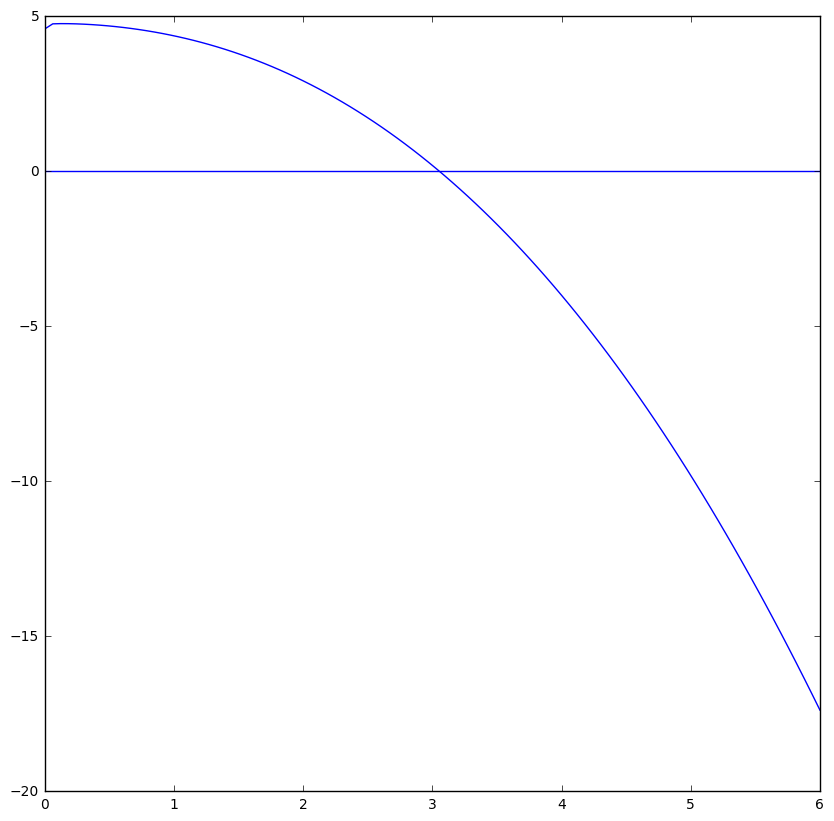

nu =  [ 3.05558421]
sigmasq =  0.710649


In [49]:
#Use fsolve here to find where nu is equal to the bias value
nu = fsolve(bnu,x0=3,args = (5.6))
#sigma = peak_height(nu)
#Test from Tinker 2010 which gives a nu value and a corresponding M_DM. I get values very similar upon testing
sigma = peak_height(2)

#Square sigma to find the R value in the integral equation
sigsq = sigma**2

#Plot bnu to visually inspect where the function is zero for a given bias
r = np.linspace(0,6,100)
plt.figure(1,figsize = (10,10))
plt.plot(r,bnu(r,5.6))
plt.axhline(0)
plt.xlim(0,6)
plt.show()

print 'nu = ', nu
print 'sigmasq = ',sigsq

## Compute the Power spectrum using CAMB with my cosmology
##### This section of code is from the Limbers equation script 

In [4]:
# Compute the matter power spectrum from CAMB and Generate the P(z,k) function to output the power at any given redshift
#and wavenumber

#First define Planck 2015 cosmological parameters
H = 70 #H0. 
oc = 0.229 #physical density of CDM 
ob = 0.046 #physical density of baryons

#Tinker 2010 L1000W
#H = 70 #H0. 
#oc = 0.23 #physical density of CDM 
#ob = 0.04 #physical density of baryons

#Conversion to density param: Omega_Matter = (oc+ob)/(H0/100.)**2

#Set up parameters in CAMB
pars = camb.CAMBparams()
#H0 is hubble parameter at z=0, ombh2 is the baryon density (physical), omch2 is the matter density (physical)
#mnu is sum of neutrino masses, omk is curvature parameter (set to 0 for flat), meffsterile is effective mass of sterile neutrinos
#pars.set_cosmology(H0=H,ombh2=ob, omch2=oc,omk=0)#,mnu=0,meffsterile=0) 

#Hard code the cosmolgy params
pars.H0=H #hubble param (No h!!)
pars.omegab=ob #Baryon density parameter
pars.omegac=oc #CDM density parameter
pars.omegav=0.725 #Vacuum density parameter
pars.set_dark_energy()

#Set parameters using standard power law parameterization.If nt=None, uses inflation consistency relation.
#ns is scalar speectral index
pars.InitPower.set_params(ns=0.960)
camb.set_halofit_version(version='original') #uses the Smith 2003 halo model
ze=np.linspace(0,20,150)
ka=np.logspace(-3,3,len(ze))#np.linspace(0,10,100)
#Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
#pars: input parameters, zs: redshift range, nonlinear: generate nonlinear power spectrum, hubble_units=True: output as Mpc/h^3 
#instead of Mpc^3 
PK = camb.get_matter_power_interpolator(pars,zs = ze,zmax = ze[-1], nonlinear=True, hubble_units=True, k_hunit=True, kmax = ka[-1])
#Generate the power using the interpolator and the z and k arrays
#Power = PK.P(z,k)

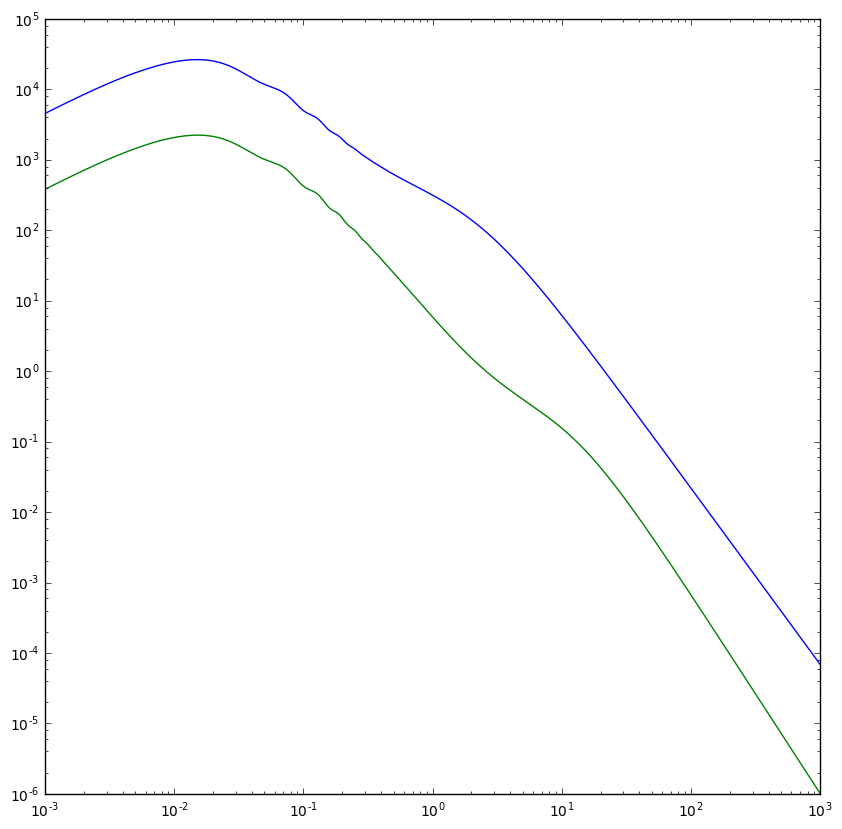

In [5]:
#Plot the linear power spectrum
# Tinker 2010 dictates that we use the linear power as opposed to nonlinear (why??)
kay = np.logspace(-3,3,1000)
plt.figure(2,figsize = (10,10))
plt.plot(kay,PK.P(0,kay))
plt.plot(kay,PK.P(3.5,kay))
plt.xscale('log')
plt.yscale('log')
plt.show()

# Below we solve for the integral equation
## We begin by solving the integral for a range of R values and plot to see where they cross zero for a given nu
## We then convert the R to MBH and plot again 
## Then we find the R that solves the sigma^2 equation and solve for MBH

In [20]:
def integrand(k,R,z,power):
        itg = 1/(2*np.pi**2)*power.P(z,k)*(3*(np.sin(k*R) - k*R*np.cos(k*R))/(k*R)**3)**2*k**2
        return itg

ra = np.logspace(-3,3,1000)
sgsq = []
for i in range(len(ra)):
    #To test Tinker 2010 results at z=0
    #integral = quad(integrand,0.001,1000,args = (ra[i],0,PK))
    #My results with our average redshift=3.5
    integral = quad(integrand,0.001,1000,args = (ra[i],3.5,PK))
    sgsq.append(integral[0])


#Compute mass from R
Mass = ra**3* 4.0 * np.pi * rhobar(1,0.275)/3.0
#Mass = 4.0/3.0*np.pi*2.78e11*0.275*ra**3


/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


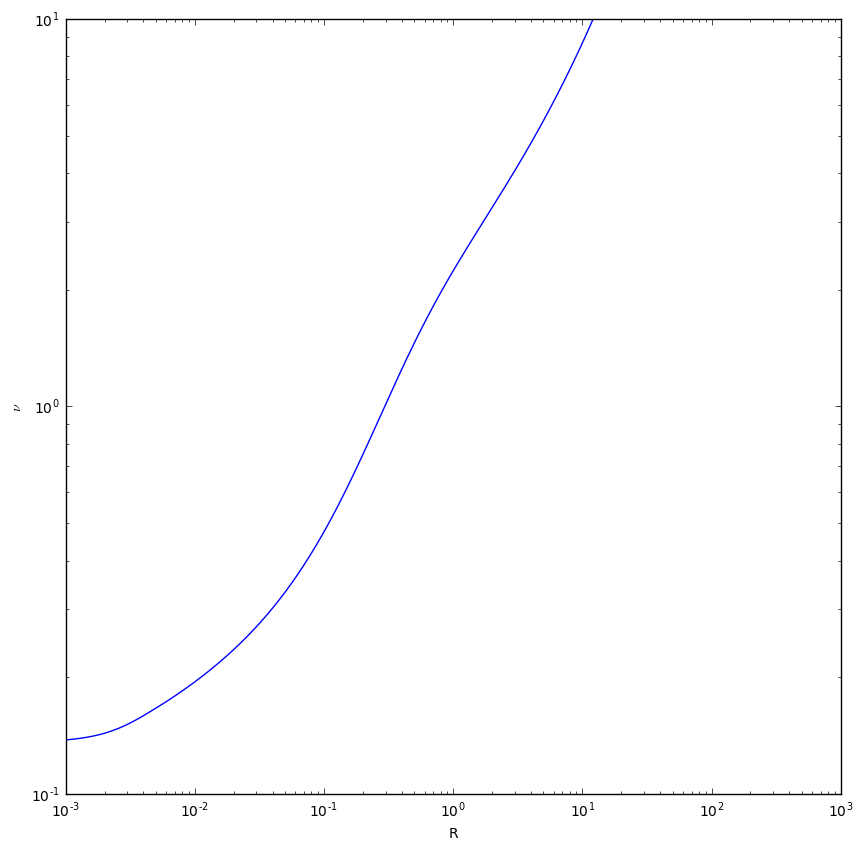

In [21]:
plt.figure(3,figsize=(10,10))
plt.plot(ra,(1.686/(np.asarray(sgsq))**0.5))
'''
plt.axhline(0.75)
plt.axhline(1)
plt.axhline(2)
plt.axhline(3)
'''
plt.xlabel('R')
plt.ylabel(r'$\nu$')
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.1,10)
plt.show()

/Users/johntimlin/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app


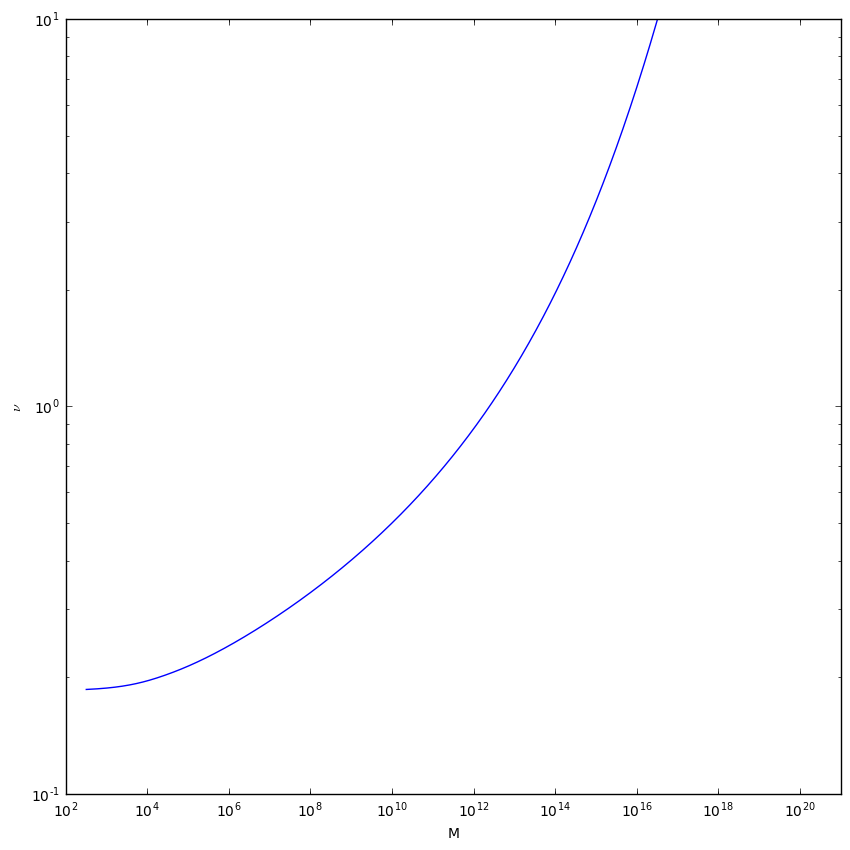

In [8]:
plt.figure(4,figsize=(10,10))
plt.plot(Mass,(1.686/(np.asarray(sgsq))**0.5))
'''
plt.axhline(0.75,color = 'b')
plt.axvline(2.9e11,color = 'b')

plt.axhline(1,color = 'm')
plt.axvline(2.8e12,color = 'm')

plt.axhline(2,color = 'r')
plt.axvline(1.2e14,color = 'r')

plt.axhline(3,color = 'g')
plt.axvline(7e14,color = 'g')
'''
plt.xlabel('M')
plt.ylabel(r'$\nu$')
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.1,10)

plt.show()

# Below is the final code for the SpIES Halos

In [3]:
# Compute the matter power spectrum from CAMB and Generate the P(z,k) function to output the power at any given redshift
#and wavenumber

#First define Planck 2015 cosmological parameters
H = 70 #H0. 
oc = 0.229 #physical density of CDM 
ob = 0.046 #physical density of baryons

#Tinker 2010 L1000W
#H = 70 #H0. 
#oc = 0.23 #physical density of CDM 
#ob = 0.04 #physical density of baryons

#Conversion to density param: Omega_Matter = (oc+ob)/(H0/100.)**2

#Set up parameters in CAMB
pars = camb.CAMBparams()
#H0 is hubble parameter at z=0, ombh2 is the baryon density (physical), omch2 is the matter density (physical)
#mnu is sum of neutrino masses, omk is curvature parameter (set to 0 for flat), meffsterile is effective mass of sterile neutrinos
#pars.set_cosmology(H0=H,ombh2=ob, omch2=oc,omk=0)#,mnu=0,meffsterile=0) 

#Hard code the cosmolgy params
pars.H0=H #hubble param (No h!!)
pars.omegab=ob #Baryon density parameter
pars.omegac=oc #CDM density parameter
pars.omegav=0.725 #Vacuum density parameter
pars.set_dark_energy()

#Set parameters using standard power law parameterization.If nt=None, uses inflation consistency relation.
#ns is scalar spectral index
pars.InitPower.set_params(ns=0.960)
camb.set_halofit_version(version='original') #uses the Smith 2003 halo model
ze=np.linspace(0,20,150)
ka=np.logspace(-4,1,len(ze))#np.linspace(0,10,100)
#Get the matter power spectrum interpolation object (based on RectBivariateSpline). 
#pars: input parameters, zs: redshift range, nonlinear: generate nonlinear power spectrum, hubble_units=True: output as Mpc/h^3 
#instead of Mpc^3 
PK = camb.get_matter_power_interpolator(pars,zs = ze,zmax = ze[-1], nonlinear=False, hubble_units=False, k_hunit=False, kmax = ka[-1])
#Generate the power using the interpolator and the z and k arrays
#Power = PK.P(z,k)

In [9]:
#Use fsolve here to find where nu is equal to the bias value
bias = 6.78
#errb = 1.39
errb = 1.79
rshft= 3.38

nu = fsolve(bnu,x0=3,args = (bias))
sigma = peak_height(nu)
#Square sigma to find the R value in the integral equation
sigsq = sigma**2
### Solve the sigma squared equation for R and get mass
Rad = fsolve(int_solve, x0=1, args = (sigsq,rshft,PK))

MDM = Rad[0]**3 * 4 * np.pi * rhobar(1,0.275)/3.0 * 0.7 #Multiply by h=0.7 to convert to h^-1 M_sun units

print 'Radius of collapse= %.5e'% Rad
print 'Corresponding DM Halo mass= %.5e'% MDM

Radius of collapse= 2.80576e+00
Corresponding DM Halo mass= 4.95126e+12


In [10]:
## Solve for DM halo for the upper and lower limits on the errors in the bias

nuup = fsolve(bnu,x0=3,args = (bias+errb))
sigmaup = peak_height(nuup)
sigsqup = sigmaup**2
Radup = fsolve(int_solve, x0=1, args = (sigsqup,rshft,PK))
MDMup = Radup[0]**3 * 4 * np.pi * rhobar(1,0.275)/3.0 * 0.7 #Multiply by h=0.7 to convert to h^-1 M_sun units

print 'Upper limit:'
print 'Radius of collapse= %.5e'% Radup
print 'Corresponding DM Halo mass= %.5e'% MDMup

nulo = fsolve(bnu,x0=3,args = (bias-errb))
sigmalo = peak_height(nulo)
sigsqlo = sigmalo**2
Radlo = fsolve(int_solve, x0=1, args = (sigsqlo,rshft,PK))
MDMlo = Radlo[0]**3 * 4 * np.pi * rhobar(1,0.275)/3.0 * 0.7 #Multiply by h=0.7 to convert to h^-1 M_sun units
print 'Lower limit:'
print 'Radius of collapse= %.5e'%Radlo
print 'Corresponding DM Halo mass= %.5e'% MDMlo


Upper limit:
Radius of collapse= 3.52671e+00
Corresponding DM Halo mass= 9.83268e+12
Lower limit:
Radius of collapse= 1.96388e+00
Corresponding DM Halo mass= 1.69788e+12


In [6]:
def SHM(M):
    val = M*2*0.0101*((M/10**12.21)**-0.82 + (M/10**12.21)**0.46)**-1
    return val
def BHM(M,z):
    val = -8.5+(4.0/3.0)*np.log10(M)-np.log10((0.725+0.275*(1+z)**3)**(2/3)/(1+z)**(0.19))
    return val

In [7]:
print np.log10(SHM(MDMlo))
print np.log10(SHM(MDMup))

10.2224145635
10.8508896434


In [8]:
print BHM(MDMlo,3.38)
print BHM(MDMup,3.38)

7.91105013159
8.85376367953
